# HW 3 Convex Optimisation

## Question 2

In [10]:
## Shape des variables

# A --> R^n*2d
# Q --> R^n**2
# v, p --> R^n
# b --> R^2n

###

import numpy as np
import cvxpy as cp
import warnings
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm



In [11]:
def value_g(Q, p, A, b, t, v):
    value = t * (v.T[np.newaxis] @ Q @ v + p.T[np.newaxis] @ v) - np.sum(np.log(b - A @ v))
    return value[0]

def value_dual(Q, p, v):
    return v.T[np.newaxis] @ Q @ v + p.T[np.newaxis] @ v

def gradiant_g(Q, p, A, b, t, v):
    gradient = 2 * t * (Q @ v) + t * p + np.sum(A * np.reciprocal(b - A @ v)[:, np.newaxis], axis=0)
    return gradient

def hessian_g(Q, A, b, t, v):
    sum_term = np.power(b - A @ v, 2)
    hessian_sum = A[0][np.newaxis].T @ A[0][np.newaxis] / sum_term[0]
    for i in range(1, 2 * d):
        hessian_sum += A[i][np.newaxis].T @ A[i][np.newaxis] / sum_term[i]
    hessian = 2 * t * Q + hessian_sum
    return hessian


In [12]:
def line_search(v, dv, alpha=0.5, beta=0.9):
    t = 1
    while t > 1e-6:
        objective_v = value_g(Q, p, A, b, t, v)
        objective_dv = value_g(Q, p, A, b, t, v + t * dv)
        gradient_v = gradiant_g(Q, p, A, b, t, v)

        criterion = objective_v + alpha * t * (gradient_v.T @ dv)
        stopping_criterium = (objective_dv < criterion)

        if stopping_criterium:
            break

        if np.any(b - A @ (v + t * dv) <= 0):
            return t

        t *= beta

    return t

def centering_step(Q, p, A, b, t, v0, eps, max_iter=500):
    nb_iter = 0
    stopping_criterium = False
    v = v0.copy()
    v_n = [v0]
    i = 0

    while not stopping_criterium and i < max_iter:
        i += 1
        grad_g = gradiant_g(Q, p, A, b, t, v)
        hess_g = hessian_g(Q, A, b, t, v)
        delta_v = np.linalg.pinv(hess_g) @ grad_g
        step = line_search(v, delta_v)
        v = v - step * delta_v
        v_n.append(v)
        lambda2 = grad_g.T @ delta_v
        stopping_criterium = (lambda2 / 2 <= eps)
        nb_iter += 1

    return v_n, nb_iter

def barr_method(Q, p, A, b, v0, eps, mu=2, t=1, max_iter=500):
    nb_iter = 0
    stopping_criterium = False
    v = v0.copy()
    v_n = []
    m = A.shape[0]
    i = 0

    while not stopping_criterium and i < max_iter:
        i += 1
        v_n.append(v)
        v_all, nb_iter_centerStep = centering_step(Q, p, A, b, t, v_n[-1], eps)
        v = v_all[-1]
        stopping_criterium = (m / t < eps)
        t *= mu
        nb_iter += nb_iter_centerStep

    return v_n, nb_iter




## Question 3

In [13]:
np.random.seed(784)

def initialize_problem(n=4, d=3, lmbda=10):
    v0 = np.zeros(n)
    eps = 0.01
    X = np.random.rand(n, d)
    y = np.random.rand(n)
    Q = np.eye(n) / 2
    p = -y.copy()
    A = np.concatenate([X.T, -X.T])
    b = lmbda * np.ones(2 * d)
    return X, y, Q, p, A, b, v0, eps


In the next cell, the calculation of the sequences for $v$ is done for different values of $\mu$ : 2, 15, 50, 100, 250, 500 and 1000.

Then for each of the obtained sequences, the associated dual value is calculated.

In [14]:
np.random.seed(2022)

# Initialisation des paramètres
n, d = 40, 50
X, y, Q, p, A, b, v0, eps = initialize_problem(n, d)
eps = 1e-9

mu_values = [2, 15, 50, 100, 250, 500, 1000]
results = []

# Calcul des séquences pour différentes valeurs de mu
for mu in tqdm(mu_values):
    v_sequence, iterations = barr_method(Q, p, A, b, v0, eps=eps, mu=mu, t=1)
    results.append(v_sequence)

# Calcul des valeurs du dual pour toutes les séquences
dual_values = [[value_dual(Q, p, v) for v in results[i]] for i in range(len(results))]


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]C:\Users\DAO.EZSPACE\AppData\Local\Temp\ipykernel_20604\83268961.py:2: RuntimeWarning: invalid value encountered in log
  value = t * (v.T[np.newaxis] @ Q @ v + p.T[np.newaxis] @ v) - np.sum(np.log(b - A @ v))
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:52<00:00,  7.50s/it]


Once all sequences are obtained for the different $\mu$ values tested, let's represent the gap $f(v)-f^{*}$ versus the number of iterations.

C:\Users\DAO.EZSPACE\AppData\Local\Temp\ipykernel_20604\83268961.py:2: RuntimeWarning: invalid value encountered in log
  value = t * (v.T[np.newaxis] @ Q @ v + p.T[np.newaxis] @ v) - np.sum(np.log(b - A @ v))


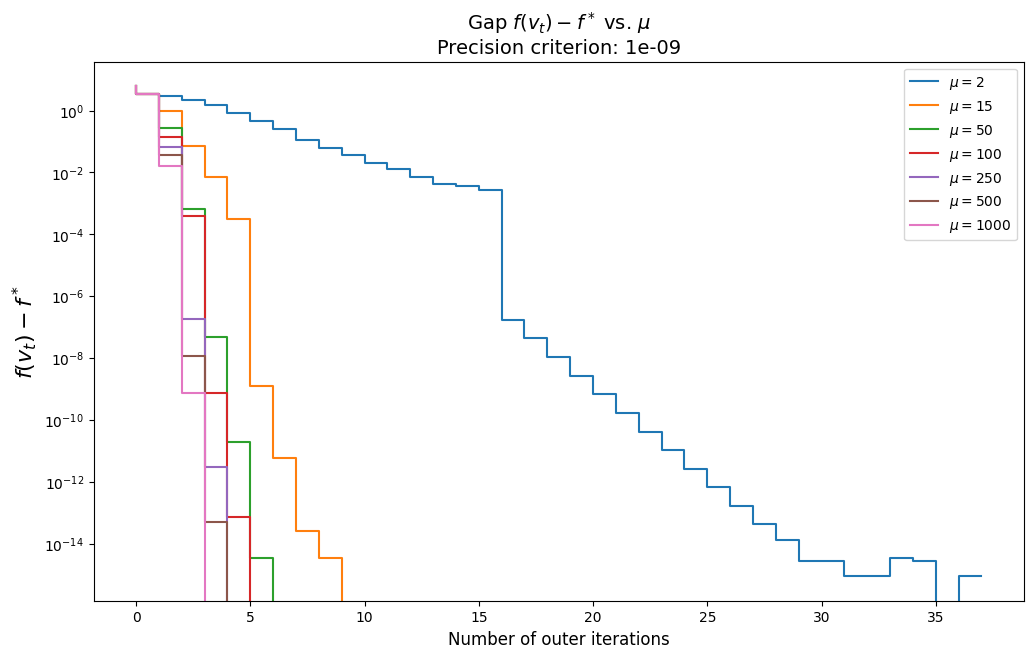

In [15]:
plt.figure(figsize=(12, 7))

iteration_counts, objective_gaps = [], []

for mu in mu_values:
    v_list, iterations = barr_method(Q, p, A, b, v0, eps=eps, mu=mu, t=1)
    iteration_counts.append(iterations)
    gap_list = []

    best_value = min(value_dual(Q, p, v) for v in v_list)

    for v in v_list:
        gap = value_dual(Q, p, v) - best_value
        gap_list.append(gap[0])

    plt.step(range(len(gap_list)), gap_list)

plt.semilogy()
plt.xlabel('Number of outer iterations', fontsize=12)
plt.ylabel('$f(v_t) - f^*$', fontsize=16)
plt.title(f'Gap $f(v_t) - f^*$ vs. $\\mu$\nPrecision criterion: {eps}', fontsize=14)
plt.legend([f'$\\mu = {x}$' for x in mu_values], loc='best')
plt.show()


We conclude that **μ = 1000** is the fastest and the best value.


Thanks for reading Thomas Gravier